Prior to this, the raw data has been parsed through the data_clean notebook. In that notebook, irregularities in the dataset have been removed which were consequences of the scraping.

In this file, we will further explore the data, remove outliers, and try to learn as much about the data as possible.

Let's import the needed libraries and change the settings

In [2]:
import numpy as np
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

Reading in the main cleaned dataframe. The body column was very sparse, so we discarded it altogether.

In [3]:
df = pd.read_csv('data_clean_NoNaN_body.csv')
df

,Title,Seller,Price,Location,Year,Ran,Engine Type,Transmission,province
0,Fiat Doblo Cargo 1.9 JTD Grijs Kenteken Bestel...,I Boumans,"18.500,-",Gennep,2005,199.313 km,Diesel,Handgeschakeld,Limburg
1,Ford Ranger Open-laadbak 2.2TDCI 160PK Dubbele...,DUTCH Vans,"22.600,-",Barneveld,2017,107.195 km,Diesel,Handgeschakeld,Gelderland
2,Aixam Roadline -2008- incl. 3 mnd garantie + o...,Garage Kaal & Buunk,"6.950,-",Beek,2008,47.108 km,Diesel,Automaat,Limburg
3,Mercedes-Benz Sprinter 314CDI 143pk L2H2 Koelw...,Van der Wal Vans,"32.900,-",Langerak,2018,148.939 km,Diesel,Handgeschakeld,Drenthe
4,Opel Corsa 1.2 Turbo Start/stop 100pk Aut 2021...,Adam,"18.500,-",Amsterdam,2021,26.200 km,Benzine,Automaat,Noord-Holland
...,...,...,...,...,...,...,...,...,...
8891,Renault Trafic L2 H1 2021 €344 per maand,Action Lease,"24.700,-",Heel Nederland,2021,67.051 km,Diesel,Handgeschakeld,In every province
8892,Renault Master L3 H1 2022 €635 per maand,Action Lease,"41.800,-",Heel Nederland,2022,60 km,Diesel,Handgeschakeld,In every province
8893,Iveco Daily L2 H2 2022 €648 per maand,Action Lease,"42.600,-",Heel Nederland,2022,30 km,Diesel,Automaat,In every province
8894,Volkswagen Crafter L2 H2 2017 €247 per maand,Action Lease,"17.600,-",Heel Nederland,2017,198.504 km,Diesel,Handgeschakeld,In every province


In order to work with the values in the columns, we must convert numerical values to numbers, rather than string. This can be done using regex.

In [4]:
df['Price'] = df['Price'].str.replace('[^0-9]', '', regex=True)
df['Price'] = df['Price'].replace('', np.nan)
df = df.dropna(subset=['Price'])
df['Price'] = pd.to_numeric(df['Price'])
df['Ran'] = df['Ran'].str.replace('[^0-9]', '', regex=True)
df['Price'] = df['Price'].replace('', np.nan)
df = df.dropna(subset=['Price'])
df['Ran'] = pd.to_numeric(df['Ran'])
df

C:\Users\ARIESE~1\AppData\Local\Temp/ipykernel_5664/1148877978.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Price'] = pd.to_numeric(df['Price'])
C:\Users\ARIESE~1\AppData\Local\Temp/ipykernel_5664/1148877978.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Ran'] = df['Ran'].str.replace('[^0-9]', '', regex=True)
C:\Users\ARIESE~1\AppData\Local\Temp/ipykernel_5664/1148877978.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

,Title,Seller,Price,Location,Year,Ran,Engine Type,Transmission,province
0,Fiat Doblo Cargo 1.9 JTD Grijs Kenteken Bestel...,I Boumans,18500,Gennep,2005,199313,Diesel,Handgeschakeld,Limburg
1,Ford Ranger Open-laadbak 2.2TDCI 160PK Dubbele...,DUTCH Vans,22600,Barneveld,2017,107195,Diesel,Handgeschakeld,Gelderland
2,Aixam Roadline -2008- incl. 3 mnd garantie + o...,Garage Kaal & Buunk,6950,Beek,2008,47108,Diesel,Automaat,Limburg
3,Mercedes-Benz Sprinter 314CDI 143pk L2H2 Koelw...,Van der Wal Vans,32900,Langerak,2018,148939,Diesel,Handgeschakeld,Drenthe
4,Opel Corsa 1.2 Turbo Start/stop 100pk Aut 2021...,Adam,18500,Amsterdam,2021,26200,Benzine,Automaat,Noord-Holland
...,...,...,...,...,...,...,...,...,...
8891,Renault Trafic L2 H1 2021 €344 per maand,Action Lease,24700,Heel Nederland,2021,67051,Diesel,Handgeschakeld,In every province
8892,Renault Master L3 H1 2022 €635 per maand,Action Lease,41800,Heel Nederland,2022,60,Diesel,Handgeschakeld,In every province
8893,Iveco Daily L2 H2 2022 €648 per maand,Action Lease,42600,Heel Nederland,2022,30,Diesel,Automaat,In every province
8894,Volkswagen Crafter L2 H2 2017 €247 per maand,Action Lease,17600,Heel Nederland,2017,198504,Diesel,Handgeschakeld,In every province


Let's take a deeper look at the price column. As we can see the highest price of a listed car is more than 3 million euros while the mean is only 18867 euros so we will look to remove some super high priced cars as outliers as they don't accurately represent the dataset.

In [5]:
pd.options.display.float_format = '{:.2f}'.format
df["Price"].describe()

count      8788.00
mean      18867.52
std       49389.25
min           0.00
25%        1686.75
50%       14700.00
75%       24900.00
max     3399999.00
Name: Price, dtype: float64

As we can see below cars with a listing price more than 150k only make up 0.3% of all listings, there are also major outliers, like cars worth millions. For the sake of this project, we will discard these very high value cars.

In [6]:
count = 0
for price in df["Price"]:
    if price > 150000:
        count += 1
total = len(df["Price"])
percentage = count / total *100
number = len(df["Price"]) * (percentage /100)
percentage, number

(0.28447883477469277, 25.0)

Let's remove all cars below 500 and above 150000 euros. We want to remove cars below 500 euros because most of these are leased cars which also don't accurately represent the price of a car.

In [7]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a winsorized data frame with outliers removed
    """
    return data.loc[(data[variable] > lower) & (data[variable] < upper)]


df = remove_outliers(df, 'Price', lower=500, upper=150001)
df = df.drop_duplicates()

In [8]:
df["Price"].describe()


count     4155.00
mean     22557.92
std      19181.86
min        505.00
25%       9275.00
50%      18700.00
75%      29900.00
max     149999.00
Name: Price, dtype: float64

Let's continue by looking at the price distribuion of all car listings.

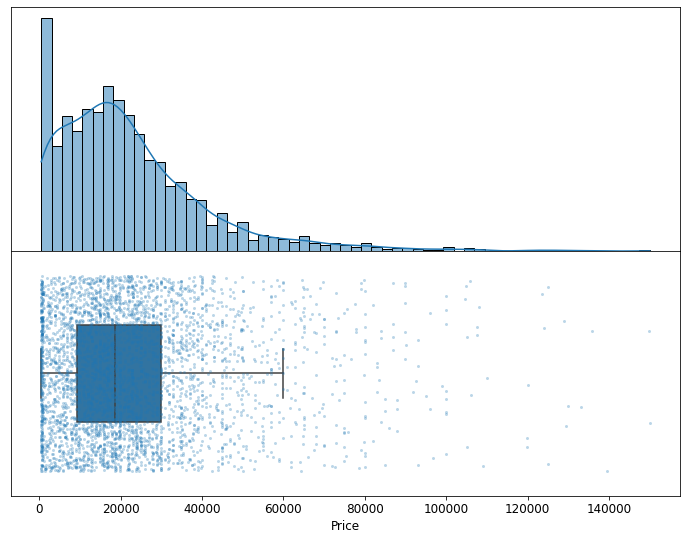

In [9]:
df = df.reset_index(drop=True)
fig, axs = plt.subplots(nrows=2)

sns.histplot(
    df["Price"],
    kde=True,
    ax=axs[0]
)

sns.stripplot(
    df["Price"], 
    orient='h',
    jitter=0.4, 
    size=3,
    ax=axs[1],
    alpha=0.3
)
sns.boxplot(
    df["Price"],
    orient='h',
    width=0.4, 
    ax=axs[1],
    showfliers=False,
)

# Align axes
spacer = np.max(df["Price"]) * 0.05
xmin = np.min(df["Price"]) - spacer
xmax = np.max(df["Price"]) + spacer
axs[0].set_xlim((xmin, xmax))
axs[1].set_xlim((xmin, xmax))

# Remove some axis text
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)
axs[1].yaxis.set_visible(False)

# Put the two plots together
plt.subplots_adjust(hspace=0)

# Adjust boxplot fill to be white
axs[1].set_facecolor('white')

The very obvious outlier is the lowest price bin. In the collection of the data, we attempted to collect private and company listings seperately, marktplaats, however, did not do a very good job at that. We loaded the dataframe as a whole, meaning that we have both private and company listings in the dataframe. The low price  listings are very likely lease options, in which we are not interested. We tried to remove these before but it seems there are still a lot of lease cars price higher dan 500 euros.
Let's take a look.

In [10]:
df.loc[df.Price<1000]

,Title,Seller,Price,Location,Year,Ran,Engine Type,Transmission,province
128,Porsche Cayenne 4.8 GTS | Sport chrono | Leder...,ROS finance,626,Veenendaal,2012,162865,Benzine,Automaat,Utrecht
129,Audi Q5 55 TFSI e 367PK 20INCH 3X S-LINE LUCHT...,ROS finance,879,Veenendaal,2020,32765,Overige brandstoffen,Automaat,Utrecht
137,Mercedes-Benz A-Klasse 200 *AMG EDITION 1* Pan...,ROS finance,621,Veenendaal,2018,39945,Benzine,Automaat,Utrecht
153,Nissan Almera 2.2 Di Luxury airco 4drs 2000 blauw,HSV Auto's,999,Vaassen,2000,250000,Diesel,Handgeschakeld,Gelderland
253,Peugeot 206 1.4 X-line 3D 2001 Blauw,Hofman,900,Rotterdam,2001,149000,Benzine,Handgeschakeld,Zuid-Holland
...,...,...,...,...,...,...,...,...,...
4064,Volkswagen Fox 1.2 Trendline,Autohandel Honing,850,Amersfoort,2006,220516,Benzine,Handgeschakeld,Utrecht
4069,Mercedes-Benz CLK-klasse Coupé 200 Sport,Autohandel Honing,995,Amersfoort,1997,353664,Benzine,Handgeschakeld,Utrecht
4104,Mercedes-Benz Sprinter | 319,Regeljelease.nl,763,Heel Nederland,2021,76857,Diesel,Automaat,In every province
4118,Mercedes-Benz Sprinter | 319 3.0 CDI V6 Aut. L2H2,Regeljelease.nl,796,Heel Nederland,2021,88534,Diesel,Automaat,In every province


Looking at the table above shows that many of these cars are leases. This can be seen by the fact that the seller name and title contain the word lease, and also by the fact that cars under 1000 should mostly be low value old cars, not a 2012 4.8 Porsche Cayenne :).

We can try to remove lease options by first of all looking at which titles and sellers contain the words lease, finance, etc.
We could also make an argument for a correlation between Year and price, and decide that cars built after a certain year should not be less than 1000 euros.
Let's remove all listings in which the Title or the Seller contain the words lease or finance

In [11]:
df = df[~df.Title.str.contains('lease|finance', case=False)]
df = df[~df.Seller.str.contains('lease|finance', case=False)]
df

,Title,Seller,Price,Location,Year,Ran,Engine Type,Transmission,province
0,Fiat Doblo Cargo 1.9 JTD Grijs Kenteken Bestel...,I Boumans,18500,Gennep,2005,199313,Diesel,Handgeschakeld,Limburg
1,Ford Ranger Open-laadbak 2.2TDCI 160PK Dubbele...,DUTCH Vans,22600,Barneveld,2017,107195,Diesel,Handgeschakeld,Gelderland
2,Aixam Roadline -2008- incl. 3 mnd garantie + o...,Garage Kaal & Buunk,6950,Beek,2008,47108,Diesel,Automaat,Limburg
3,Mercedes-Benz Sprinter 314CDI 143pk L2H2 Koelw...,Van der Wal Vans,32900,Langerak,2018,148939,Diesel,Handgeschakeld,Drenthe
4,Opel Corsa 1.2 Turbo Start/stop 100pk Aut 2021...,Adam,18500,Amsterdam,2021,26200,Benzine,Automaat,Noord-Holland
...,...,...,...,...,...,...,...,...,...
4125,Mercedes 519 DOKA V 6 autotransporter/oprijwag...,Kegger Sp.z o.o.,89999,Heel Nederland,2022,50,Diesel,Automaat,In every province
4136,Volkswagen Crafter H1 L5 Diesel 2012 Groen,Dutchvans.com,14600,Barneveld,2012,183398,Diesel,Handgeschakeld,Gelderland
4137,Ford Transit Kipper 2.0TDCI 3-Zijdige Kipper |...,DUTCH Vans,16700,Barneveld,2016,95864,Diesel,Handgeschakeld,Gelderland
4138,Mercedes-Benz Sprinter H1 L4 Diesel 2018 Wit,Dutchvans.com,19300,Barneveld,2018,226713,Diesel,Handgeschakeld,Gelderland


That removed quite some rows! Let's look at the price distribution again.

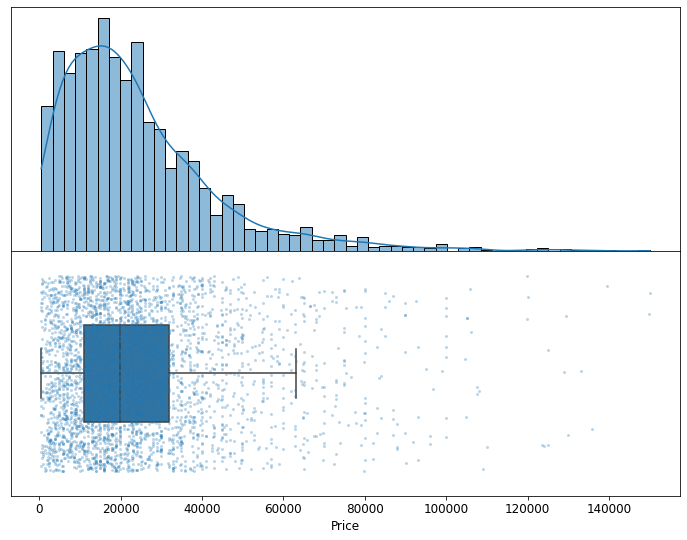

In [12]:
df = df.reset_index(drop=True)
fig, axs = plt.subplots(nrows=2)

sns.histplot(
    df["Price"],
    kde=True,
    ax=axs[0]
)

sns.stripplot(
    df["Price"],
    orient='h',
    jitter=0.4,
    size=3,
    ax=axs[1],
    alpha=0.3
)
sns.boxplot(
    df["Price"],
    orient='h',
    width=0.4,
    ax=axs[1],
    showfliers=False,
)

# Align axes
spacer = np.max(df["Price"]) * 0.05
xmin = np.min(df["Price"]) - spacer
xmax = np.max(df["Price"]) + spacer
axs[0].set_xlim((xmin, xmax))
axs[1].set_xlim((xmin, xmax))

# Remove some axis text
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)
axs[1].yaxis.set_visible(False)

# Put the two plots together
plt.subplots_adjust(hspace=0)

# Adjust boxplot fill to be white
axs[1].set_facecolor('white')

This distribution makes much more sense.
Let's also look at the correlation between the Year the car was built and the Price.

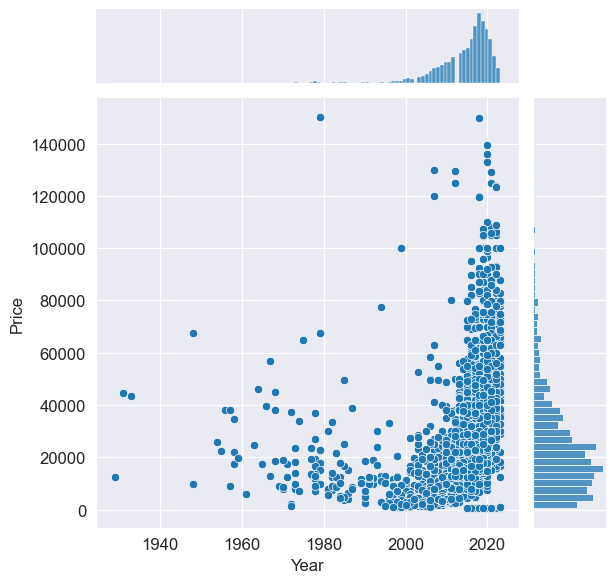

In [120]:
sns.jointplot(x='Year', y='Price', data=df)

We are removing cars before the year of 1990, as they cause much noise but are relatively sparse. They are noisy because some old cars have high value because of their old age, while othersare simply old and unreliable and therefore have the opposite effect. This is difficult to predict, and adds more noise that it does good.

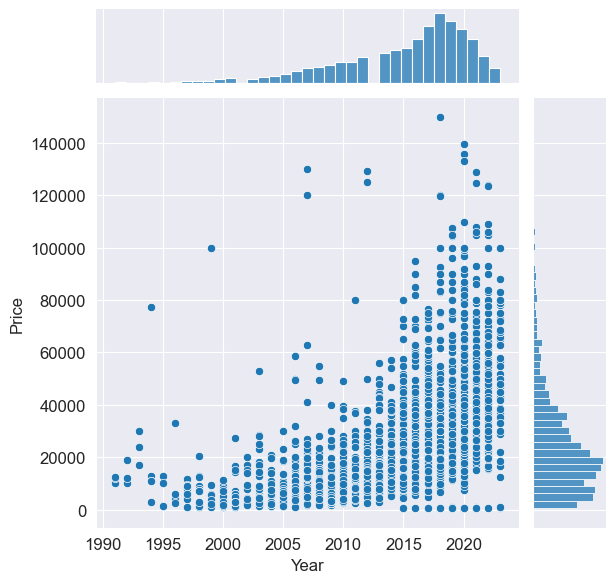

In [121]:
df = df[df.Year>1990]
sns.jointplot(x='Year', y='Price', data=df)

In this plot we can see that, from from 2005 to 2015, no cars are in the lowest price bracket. However, from 2015 to current, that bracket is populated again. Let's try removing all cars that are built from 2014 onwards, but are listed at a price lower than 1000 euros. These are very likely lease options.

In [122]:
df[(df.Year>=2013) & (df.Price<=1000)]

,Title,Seller,Price,Location,Year,Ran,Engine Type,Transmission,province
509,Mercedes-Benz Sprinter 317CDI 170pk L3H2 Euro6...,Van der Wal Vans,616,Langerak,2021,48687,Diesel,Handgeschakeld,Drenthe
571,"Dodge Ram 1500 5.7 V8 Limited Night, op voorra...",Millbrooks,899,Nuland,2023,10,LPG,Automaat,Noord-Brabant
752,Renault Master 10x Bakwagen met 1000 kg laadkl...,Vissinga Automotive B.V.,520,Arnhem,2023,150,Diesel,Handgeschakeld,Gelderland
814,Volkswagen Crafter 2.0TDI 140PK Automaat L3H2 ...,Dethi Vans,709,Vaassen,2022,34,Diesel,Automaat,Gelderland
947,Mercedes-Benz Sprinter 319 3.0CDI V6 190PK Aut...,Bedrijfswagen centrum Leeuwarden,687,Leeuwarden,2020,27157,Diesel,Automaat,Fryslân
1050,Ford Transit Custom 2.0TDCI Lang RAPTOR Editio...,Dethi Vans,516,Vaassen,2021,38669,Diesel,Handgeschakeld,Gelderland
1116,Mercedes-Benz Sprinter 316CDI 163pk L3H2 Euro6...,Van der Wal Vans,551,Langerak,2020,92866,Diesel,Handgeschakeld,Drenthe
1393,Mercedes-Benz Sprinter 316CDI 163pk Bakwagen +...,Van der Wal Vans,535,Langerak,2019,135193,Diesel,Handgeschakeld,Drenthe
1674,Dodge Ram 1500 Nieuw 2023 met LPG 6 jaar fabri...,Millbrooks,799,Nuland,2023,1,LPG,Automaat,Noord-Brabant
1676,Dodge Ram 1500 Nieuw 2023 met LPG 6 jaar fabri...,Millbrooks,799,Nuland,2023,1,LPG,Automaat,Noord-Brabant


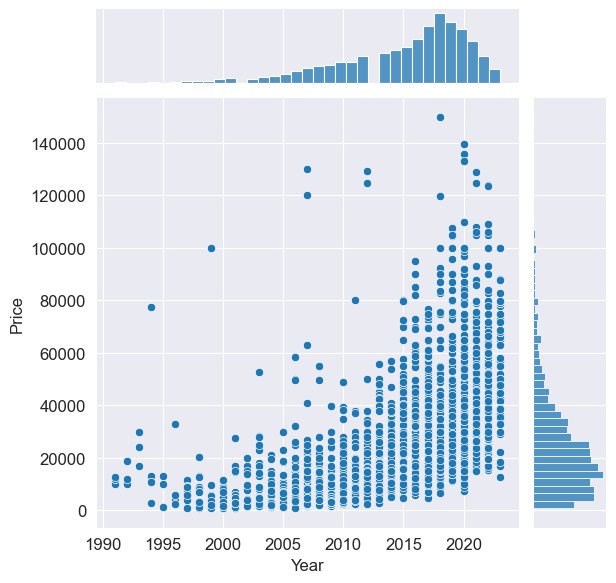

In [123]:
df = df[(df.Year<=2013) | (df.Price>=1000)]
sns.jointplot(x='Year', y='Price', data=df)

That looks good!

There are some cars which are relatively old, with very high prices. Let's manually inspect these.

In [124]:
df[(df.Year<2000) & (df.Price>=60000)]

,Title,Seller,Price,Location,Year,Ran,Engine Type,Transmission,province
1497,Porsche 911 Cabrio 3.6 | Carrera | Automaat (b...,Selles Autos Kamperzeedijk B.V.,77500,Genemuiden,1994,209810,Benzine,Automaat,Overijssel
2268,Ferrari 360 3.6 V8 Modena / Handgeschakelde 6 ...,EAF Auto's,99950,Voorschoten,1999,60246,Benzine,Handgeschakeld,Zuid-Holland


In [125]:
df[df.Price>=115000]

,Title,Seller,Price,Location,Year,Ran,Engine Type,Transmission,province
501,Porsche CAYENNE 4.0 Turbo Akrapovic XPEL (PPF),Automotive Experience,119950,Vianen,2018,91500,Benzine,Automaat,Noord-Brabant
671,Ferrari FF 6.3 V12 HELE,Autozaak Rivo,124950,Stadskanaal,2012,74658,Benzine,Automaat,Groningen
676,Ferrari California 4.3 V8 460PK F1 Keramisch C...,Autoplein Nijkerk,129400,Nijkerk,2012,16400,Benzine,Automaat,Gelderland
785,BMW X7 xDrive 40d 340 pk M Sportpakket Sky Lou...,Lenferink Auto's B.V.,124900,Almelo,2021,46297,Diesel,Automaat,Overijssel
908,BMW 4 Serie Coupé M4 Competition Race Track *M...,Horse Power Factory,128950,Winterswijk,2021,14174,Benzine,Automaat,Gelderland
1194,BMW X7 M M50D 400PK 7Pers High Executive Bower...,Bedrijfswagen centrum Leeuwarden,135850,Leeuwarden,2020,59500,Diesel,Automaat,Fryslân
1553,BMW 3 Serie M3 xDrive Competition SPORTSTOELEN...,Ros Automotive,123950,Veenendaal,2022,12342,Benzine,Automaat,Utrecht
1555,Mercedes-Benz AMG GT 4.0 C | 50 YEARS EDITION ...,Ros Automotive,149750,Veenendaal,2018,10123,Benzine,Automaat,Utrecht
1986,Land Rover Range Rover Sport 5.0 V8 Supercharg...,JD,119750,Veenendaal,2018,97580,Benzine,Automaat,Utrecht
2103,Mercedes-Benz S400D/ 4Matic/Burmeister4D/ FULL...,Godfried,123500,Almelo,2022,10000,Diesel,Automaat,Overijssel


These are all luxury vehicles. Let's remove them for now.

In [126]:
df = df[(df.Year>=2000) | (df.Price<=60000)]

In [127]:
df = remove_outliers(df, 'Price', upper=115000)

<Axes: xlabel='Year', ylabel='Price'>

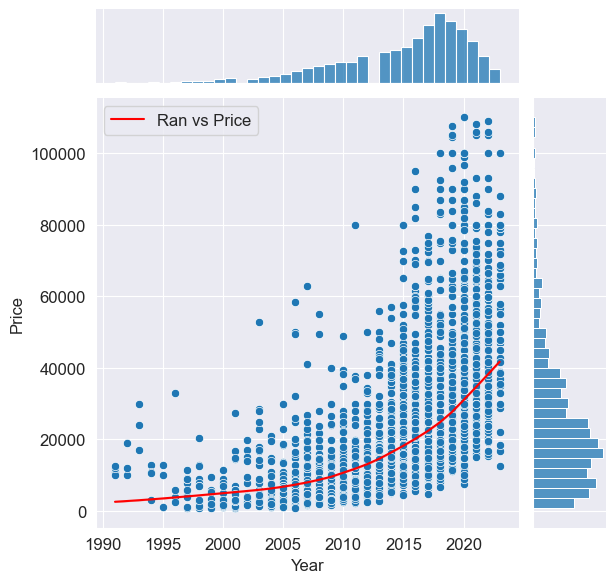

In [128]:
sns.jointplot(x='Year', y='Price', data=df)
xobs = df.Year
yobs = df.Price
ysmooth = lowess(yobs, xobs, return_sorted=False)
sns.lineplot(x=xobs, y=ysmooth, label='Ran vs Price', color='red')

Let's take a look at the correlation between the distance the car has Ran versus the price. We see a clear trend, where cars with less mileage are more expensive.

<Axes: xlabel='Price', ylabel='Ran'>

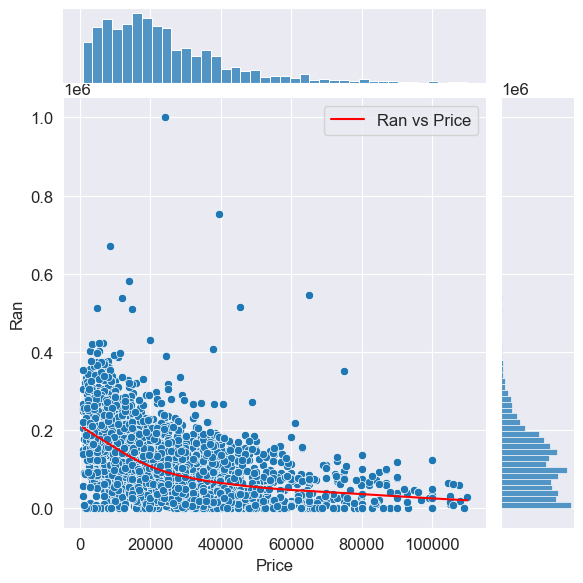

In [129]:
sns.jointplot(x='Price', y='Ran', data=df)
xobs = df.Price
yobs = df.Ran
ysmooth = lowess(yobs, xobs, return_sorted=False)
sns.lineplot(x=xobs, y=ysmooth, label='Ran vs Price', color='red')

Regressing based on year and mileage is interesting, however, a 2018 audi with 100.000 km is not the same price as a 2018 hyundai.
Let's add a column, which will represent the make of the car.

In [130]:
manufacturers = pd.read_csv('manufacturers.csv')
manufacturers.make = manufacturers.make.str.lower()
manufacturers

,make
0,alfa romeo
1,aston martin
2,audi
3,bmw
4,chevrolet
...,...
61,ssanyong
62,daihatsu
63,hummer
64,smart


In [131]:
df.Title = df.Title.str.lower()
df.Title = df.Title.str.replace('vw', 'volkswagen')

In [132]:
def extract_make(title):
    for make in manufacturers['make']:
        if make in title:
            return make
    return None
df['Make'] = df['Title'].apply(extract_make)
df['Province'] = df.province
df.drop('province',axis=1)
df = df[['Make', 'Price', 'Year', 'Ran', 'Engine Type', 'Transmission', 'Location', 'Province', 'Seller', 'Title']]

In [133]:
df = df[df.Make.notna()]
df

,Make,Price,Year,Ran,Engine Type,Transmission,Location,Province,Seller,Title
0,fiat,18500,2005,199313,Diesel,Handgeschakeld,Gennep,Limburg,I Boumans,fiat doblo cargo 1.9 jtd grijs kenteken bestel...
1,ford,22600,2017,107195,Diesel,Handgeschakeld,Barneveld,Gelderland,DUTCH Vans,ford ranger open-laadbak 2.2tdci 160pk dubbele...
2,aixam,6950,2008,47108,Diesel,Automaat,Beek,Limburg,Garage Kaal & Buunk,aixam roadline -2008- incl. 3 mnd garantie + o...
3,mercedes,32900,2018,148939,Diesel,Handgeschakeld,Langerak,Drenthe,Van der Wal Vans,mercedes-benz sprinter 314cdi 143pk l2h2 koelw...
4,opel,18500,2021,26200,Benzine,Automaat,Amsterdam,Noord-Holland,Adam,opel corsa 1.2 turbo start/stop 100pk aut 2021...
...,...,...,...,...,...,...,...,...,...,...
3508,mercedes,89999,2022,50,Diesel,Automaat,Heel Nederland,In every province,Kegger Sp.z o.o.,mercedes 519 doka v 6 autotransporter/oprijwag...
3509,volkswagen,14600,2012,183398,Diesel,Handgeschakeld,Barneveld,Gelderland,Dutchvans.com,volkswagen crafter h1 l5 diesel 2012 groen
3510,ford,16700,2016,95864,Diesel,Handgeschakeld,Barneveld,Gelderland,DUTCH Vans,ford transit kipper 2.0tdci 3-zijdige kipper |...
3511,mercedes,19300,2018,226713,Diesel,Handgeschakeld,Barneveld,Gelderland,Dutchvans.com,mercedes-benz sprinter h1 l4 diesel 2018 wit


We have 3283 rows, all of which are completely filled in and ready to be used for regression.